# EDA

In [1]:
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from catboost import Pool, CatBoostRegressor
import time
import asyncio
import aiohttp


## Feature Engineering

In [2]:
access_token = "..."

In [61]:
from typing import Tuple

async def async_get_coordinates(address: str)-> Tuple[float, float]:
    headers = {"Authorization": access_token}
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y"
    async with aiohttp.ClientSession(headers=headers) as session:        
        response = await session.get(url)
        while response.status == 429:
            print("Backing off for 10s")
            time.sleep("10")
            response = await session.get(url)

        try:
            response_json = await response.json()
            result = response_json["results"][0]
            return (result["LATITUDE"], result["LONGITUDE"])
        except Exception as e:
            print(await response.text())
            raise e

def get_coordinates(address: str)-> Tuple[float, float]:
    headers = {"Authorization": access_token}
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y"
    response = requests.request("GET", url, headers=headers)
    while response.status_code== 429:
        print("Backing off for 10s")
        time.sleep("10")
        response = requests.request("GET", url, headers=headers)
    response_json = response.json()
    print(response_json)
    result = response_json["results"][0]
    return (result["LATITUDE"], result["LONGITUDE"])

In [29]:
get_coordinates("CHIJ St. Nicholas Girls' School")

{'found': 1, 'totalNumPages': 1, 'pageNum': 1, 'results': [{'SEARCHVAL': "CHIJ SAINT NICHOLAS GIRLS' SCHOOL", 'BLK_NO': '501', 'ROAD_NAME': 'ANG MO KIO STREET 13', 'BUILDING': "CHIJ SAINT NICHOLAS GIRLS' SCHOOL", 'ADDRESS': "501 ANG MO KIO STREET 13 CHIJ SAINT NICHOLAS GIRLS' SCHOOL SINGAPORE 569405", 'POSTAL': '569405', 'X': '28104.0195931299', 'Y': '39497.6106162649', 'LATITUDE': '1.37347687878916', 'LONGITUDE': '103.834253269436'}]}


('1.37347687878916', '103.834253269436')

In [8]:
lat, long = await async_get_coordinates("174 ANG MO KIO AVE 4")

In [6]:
def get_routing_time(lat: float, long: float, dest_lat: float, dest_long: float, route_type: str) -> int:
    url = f"https://www.onemap.gov.sg/api/public/routingsvc/route?start={lat}%2C{long}&end={dest_lat}%2C{dest_long}&routeType={route_type}"
        
    headers = {"Authorization": access_token}
        
    response = requests.request("GET", url, headers=headers)
    while response.status_code == 429:
        print("Backing off for 10s")
        time.sleep("10")
        response = requests.request("GET", url, headers=headers)
    return response.json()["route_summary"]["total_time"]

In [9]:
get_routing_time(lat, long, 1.284184, 103.85151, "drive")

1297

In [32]:
def get_popular_primary_school_coordinates():
    popular_primary_schools = [
        "Methodist Girls' School (Primary)",
        "Catholic High School (Primary)",
        "Tao Nan School",
        "Pei Hwa Presbyterian Primary School",
        "Holy Innocents' Primary School",
        "Nan Hua Primary School",
        "CHIJ St. Nicholas Girls' School",
        "Admiralty Primary School",
        "St. Hilda's Primary School",
        "Ai Tong School",
        "Anglo-Chinese School (Junior)",
        "Chongfu School",
        "St. Joseph's Institution Junior",
        "Anglo-Chinese School (Primary)",
        "Singapore Chinese Girls' Primary School",
        "Nanyang Primary School",
        "South View Primary School",
        "Pei Chun Public School",
        "Kong Hwa School",
        "Rosyth School",
        "Maris Stella High School",
        "Nan Chiau Primary School",
        "Fairfield Methodist School (Primary)",
        "CHIJ Primary (Toa Payoh)",
        "Henry Park Primary School"
    ]
    lats, longs = [], []
    for school in popular_primary_schools:
        print(school)
        lat, long = get_coordinates(school)
        lats.append(lat)
        longs.append(long)
    return pd.DataFrame({"school": popular_primary_schools, "lat": lats, "long": longs})


In [33]:
primary_schools_df = get_popular_primary_school_coordinates()
primary_schools_df.to_csv("primary_schools.csv")

Methodist Girls' School (Primary)
{'found': 1, 'totalNumPages': 1, 'pageNum': 1, 'results': [{'SEARCHVAL': "PAYA LEBAR METHODIST GIRLS' SCHOOL (PRIMARY)", 'BLK_NO': '298', 'ROAD_NAME': 'LORONG AH SOO', 'BUILDING': "PAYA LEBAR METHODIST GIRLS' SCHOOL (PRIMARY)", 'ADDRESS': "298 LORONG AH SOO PAYA LEBAR METHODIST GIRLS' SCHOOL (PRIMARY) SINGAPORE 536741", 'POSTAL': '536741', 'X': '33748.3760953182', 'Y': '36843.4187818952', 'LATITUDE': '1.34947276268396', 'LONGITUDE': '103.884971343143'}]}
Catholic High School (Primary)
{'found': 1, 'totalNumPages': 1, 'pageNum': 1, 'results': [{'SEARCHVAL': 'COMMIT LEARNING SCHOOLHOUSE @ CATHOLIC HIGH SCHOOL (PRIMARY)', 'BLK_NO': '9', 'ROAD_NAME': 'BISHAN STREET 22', 'BUILDING': 'COMMIT LEARNING SCHOOLHOUSE @ CATHOLIC HIGH SCHOOL (PRIMARY)', 'ADDRESS': '9 BISHAN STREET 22 COMMIT LEARNING SCHOOLHOUSE @ CATHOLIC HIGH SCHOOL (PRIMARY) SINGAPORE 579767', 'POSTAL': '579767', 'X': '29212.1656484166', 'Y': '37386.9490167908', 'LATITUDE': '1.35438878373608', 'L

In [36]:
# From https://datamall.lta.gov.sg/content/datamall/en/search_datasets.html
mrt_stations_df = pd.read_excel("Train Station Codes and Chinese Names.xls")

def get_mrt_coordinates():
    lats, longs, mrt_stations = [], [], []
    for index, row in mrt_stations_df.iterrows():
        if "LRT" not in row["mrt_line_english"]:
            mrt_station = row["mrt_station_english"] + " MRT station"
            lat, long = get_coordinates(mrt_station)
            lats.append(lat)
            longs.append(long)
            mrt_stations.append(mrt_station)
    return pd.DataFrame({"mrt_station": mrt_stations, "lat": lats, "long": longs})


In [37]:
mrt_stations_df = get_mrt_coordinates()
mrt_stations_df.to_csv("mrt_stations.csv")

{'found': 8, 'totalNumPages': 1, 'pageNum': 1, 'results': [{'SEARCHVAL': 'JURONG EAST MRT STATION (EW24 / NS1)', 'BLK_NO': '10', 'ROAD_NAME': 'JURONG EAST STREET 12', 'BUILDING': 'JURONG EAST MRT STATION (EW24 / NS1)', 'ADDRESS': '10 JURONG EAST STREET 12 JURONG EAST MRT STATION (EW24 / NS1) SINGAPORE 609690', 'POSTAL': '609690', 'X': '17869.0570516568', 'Y': '35038.9688695427', 'LATITUDE': '1.33315281585758', 'LONGITUDE': '103.742286332403'}, {'SEARCHVAL': 'OCBC JURONG EAST MRT STATION', 'BLK_NO': '10', 'ROAD_NAME': 'JURONG EAST STREET 12', 'BUILDING': 'OCBC JURONG EAST MRT STATION', 'ADDRESS': '10 JURONG EAST STREET 12 OCBC JURONG EAST MRT STATION SINGAPORE 609690', 'POSTAL': '609690', 'X': '17869.080600149', 'Y': '35038.9471976664', 'LATITUDE': '1.33315261987295', 'LONGITUDE': '103.742286544006'}, {'SEARCHVAL': 'DBS JURONG EAST MRT STATION', 'BLK_NO': '10', 'ROAD_NAME': 'JURONG EAST STREET 12', 'BUILDING': 'DBS JURONG EAST MRT STATION', 'ADDRESS': '10 JURONG EAST STREET 12 DBS JURON

In [50]:
df = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [52]:
# Look at the unique categorical values
print(df["town"].unique())
print(df["flat_type"].unique())
print(df["storey_range"].unique())
print(df["flat_model"].unique())

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']
['3 ROOM' '4 ROOM' '5 ROOM' '2 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI-GENERATION']
['07 TO 09' '01 TO 03' '13 TO 15' '10 TO 12' '04 TO 06' '19 TO 21'
 '16 TO 18' '22 TO 24' '25 TO 27' '28 TO 30' '34 TO 36' '46 TO 48'
 '31 TO 33' '37 TO 39' '43 TO 45' '40 TO 42' '49 TO 51']
['Improved' 'New Generation' 'Model A' 'Standard' 'Simplified'
 'Premium Apartment' 'Maisonette' 'Apartment' 'Model A2' 'Type S1'
 'Type S2' 'Adjoined flat' 'Terrace' 'DBSS' 'Model A-Maisonette'
 'Premium Maisonette' 'Multi Generation' 'Premium Apartment Loft'
 'Improved-Maisonette' '2-room']


In [53]:
# Convert resale price to resale price per sqm
df["resale_price_per_sqm"] = df.resale_price / df.floor_area_sqm
df = df.drop(columns="resale_price")

# Convert month, flat_type, storey_range, flat_model to categorical values
df.month = pd.Categorical(df.month)
df.town = pd.Categorical(df.town)
df.flat_type = pd.Categorical(df.flat_type)
df.storey_range = pd.Categorical(df.storey_range)
df.flat_model = pd.Categorical(df.flat_model)

# Set types
df["block"] = df["block"].astype("string")
df["street_name"] = df["street_name"].astype("string")

In [64]:
# Get coordinates of house
import itertools


df["house_lat"] = None
df["house_long"] = None
street_name_coords = {}

async def process_get_coordinates(row_id: int, row):
    if row["street_name"]  not in street_name_coords:
        lat, long = await async_get_coordinates(row["street_name"])
        street_name_coords[row["street_name"]] = (lat, long)
    lat, long = street_name_coords[row["street_name"]]
    df.loc[row_id, ['house_lat', 'house_long']] = [[lat, long]]


async def limit_openmapapi_calls(func):
    processes = [func(index, row) for index, row in df.iterrows()]
    it = iter(processes)
    while True:
        batch = list(itertools.islice(it, 500))
        if not batch:
            break
        await asyncio.gather(*batch)  
        print("sleep starting")
        time.sleep(5)
        print("sleep complete")

await limit_openmapapi_calls(process_get_coordinates)
print(df)


/home/sytan98/anaconda3/envs/mlflow-test/lib/python3.8/site-packages/pandas/_config/config.py:619: RuntimeWarning: coroutine 'process_get_coordinates' was never awaited
  d = _deprecated_options[key]


sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep starting
sleep complete
sleep star

In [69]:
df["house_lat"] = df["house_lat"].apply(lambda x: x[0])
df["house_long"] = df["house_long"].apply(lambda x: x[0])

In [70]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price_per_sqm,house_lat,house_long
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,4250.000000,1.37647951934552,103.839458024511
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,4044.117647,1.36677040270637,103.856589829581
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,4130.434783,1.37647951934552,103.839458024511
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,4264.705882,1.36677040270637,103.856589829581
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,4264.705882,1.36677040270637,103.856589829581


In [66]:
primary_schools_df = pd.read_csv("primary_schools.csv")
mrt_stations_df = pd.read_csv("mrt_stations.csv")

In [74]:
from geopy import distance
from functools import lru_cache

@lru_cache(maxsize=None)
def calculate_geodesic_dist(start_lat: float, start_long: float, dest_lat: float, dest_long: float):
    return distance.distance((start_lat, start_long), (dest_lat, dest_long)).km

@lru_cache(maxsize=None)
def calculate_dist_to_nearest_primary_school(start_lat: float, start_long: float):
    distances = primary_schools_df.apply(lambda row: calculate_geodesic_dist(start_lat, start_long, row["lat"], row["long"]), axis=1)
    return min(distances)

@lru_cache(maxsize=None)
def calculate_dist_to_nearest_mrt_station(start_lat: float, start_long: float):
    distances = mrt_stations_df.apply(lambda row: calculate_geodesic_dist(start_lat, start_long, row["lat"], row["long"]), axis=1)
    return min(distances)

# Get CBD travel distance
RAFFLES_PLACE_LAT, RAFFLES_PLACE_LONG = 1.284184, 103.85151
# drive_time_to_cbd = []
# for index, row in df.iterrows():
#     drive_time_to_cbd.append(get_routing_time(df["house_lat"], df["house_long"], RAFFLES_PLACE_LAT, RAFFLES_PLACE_LONG, "drive"))
# df["drive_time_to_cbd"] = drive_time_to_cbd
df["distance_cbd"] = df.apply(lambda row: calculate_geodesic_dist(row["house_lat"], row["house_long"], RAFFLES_PLACE_LAT, RAFFLES_PLACE_LONG), axis=1)

# Get distance to nearest popular primary school
df["distance_top_primary"] = df.apply(lambda row: calculate_dist_to_nearest_primary_school(row["house_lat"], row["house_long"]), axis=1)

# Get distance to nearest MRT
df["distance_mrt"] = df.apply(lambda row: calculate_dist_to_nearest_mrt_station(row["house_lat"], row["house_long"]), axis=1)


In [75]:
df.to_csv("full_dataset.csv")

In [138]:
df = pd.read_csv("full_dataset.csv", index_col=0)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price_per_sqm,house_lat,house_long,distance_cbd,distance_top_primary,distance_mrt
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,4250.000000,1.37648,103.839458,10.293325,0.667635,0.641194
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,4044.117647,1.36677,103.856590,9.149463,1.942256,0.846653
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,4130.434783,1.37648,103.839458,10.293325,0.667635,0.641194
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,4264.705882,1.36677,103.856590,9.149463,1.942256,0.846653
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,4264.705882,1.36677,103.856590,9.149463,1.942256,0.846653


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37153 entries, 0 to 37152
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            37153 non-null  int64  
 1   month                 37153 non-null  object 
 2   town                  37153 non-null  object 
 3   flat_type             37153 non-null  object 
 4   block                 37153 non-null  object 
 5   street_name           37153 non-null  object 
 6   storey_range          37153 non-null  object 
 7   floor_area_sqm        37153 non-null  float64
 8   flat_model            37153 non-null  object 
 9   lease_commence_date   37153 non-null  int64  
 10  remaining_lease       37153 non-null  int64  
 11  resale_price_per_sqm  37153 non-null  float64
 12  house_lat             37153 non-null  float64
 13  house_long            37153 non-null  float64
 14  distance_cbd          37153 non-null  float64
 15  distance_top_primar

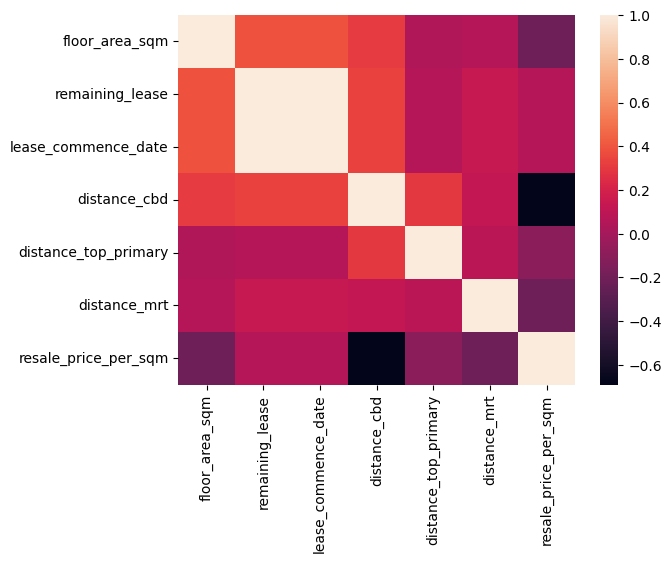

In [76]:
sns.heatmap(df[["floor_area_sqm", "remaining_lease", "lease_commence_date", "distance_cbd", "distance_top_primary", "distance_mrt", "resale_price_per_sqm"]].corr());

In [80]:
def one_hot_encode(df: pd.DataFrame, col_name: str):
    # perform one hot encoding using get_dummies
    df_onehot = pd.get_dummies(df[col_name])
    # add the one hot encoded columns to the original dataframe
    df = pd.concat([df, df_onehot], axis=1)
    return df

In [139]:
one_hot_encoded_df = one_hot_encode(df, "month")
one_hot_encoded_df = one_hot_encode(one_hot_encoded_df, "town")
one_hot_encoded_df = one_hot_encode(one_hot_encoded_df, "flat_type")
one_hot_encoded_df = one_hot_encode(one_hot_encoded_df, "storey_range")
one_hot_encoded_df = one_hot_encode(one_hot_encoded_df, "flat_model")
one_hot_encoded_df = one_hot_encoded_df.drop(columns=["month", "town", "flat_type", "storey_range", "flat_model"])
one_hot_encoded_df.head()

,block,street_name,floor_area_sqm,lease_commence_date,remaining_lease,resale_price_per_sqm,house_lat,house_long,distance_cbd,distance_top_primary,...,Multi Generation,New Generation,Premium Apartment,Premium Apartment Loft,Premium Maisonette,Simplified,Standard,Terrace,Type S1,Type S2
0,174,ANG MO KIO AVE 4,60.0,1986,70,4250.000000,1.37648,103.839458,10.293325,0.667635,...,False,False,False,False,False,False,False,False,False,False
1,541,ANG MO KIO AVE 10,68.0,1981,65,4044.117647,1.36677,103.856590,9.149463,1.942256,...,False,True,False,False,False,False,False,False,False,False
2,163,ANG MO KIO AVE 4,69.0,1980,64,4130.434783,1.37648,103.839458,10.293325,0.667635,...,False,True,False,False,False,False,False,False,False,False
3,446,ANG MO KIO AVE 10,68.0,1979,63,4264.705882,1.36677,103.856590,9.149463,1.942256,...,False,True,False,False,False,False,False,False,False,False
4,557,ANG MO KIO AVE 10,68.0,1980,64,4264.705882,1.36677,103.856590,9.149463,1.942256,...,False,True,False,False,False,False,False,False,False,False


<Axes: ylabel='Frequency'>

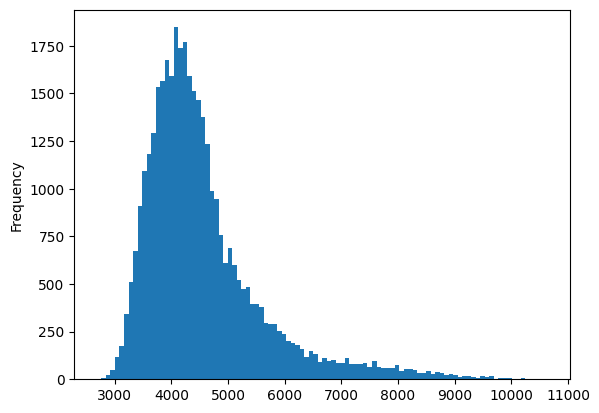

In [140]:
# View target distribution
df.resale_price_per_sqm.plot.hist(bins=100)

<Axes: ylabel='Frequency'>

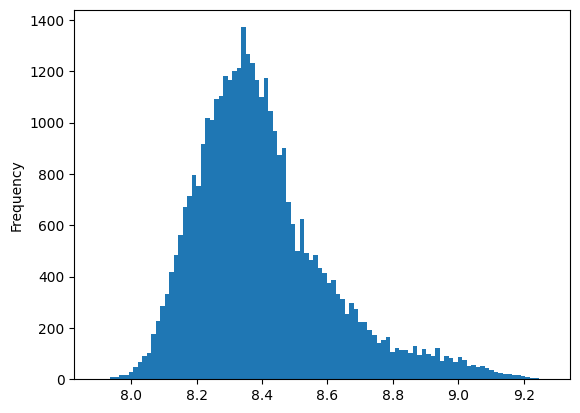

In [222]:
np.log(df.resale_price_per_sqm).plot.hist(bins=100)


## Model

## Linear Regression model

In [244]:
train_df = one_hot_encoded_df[:int(0.8*len(df))]
test_df = one_hot_encoded_df[int(0.8*len(df)):]

1.7890812028848158
1.0405277608397099


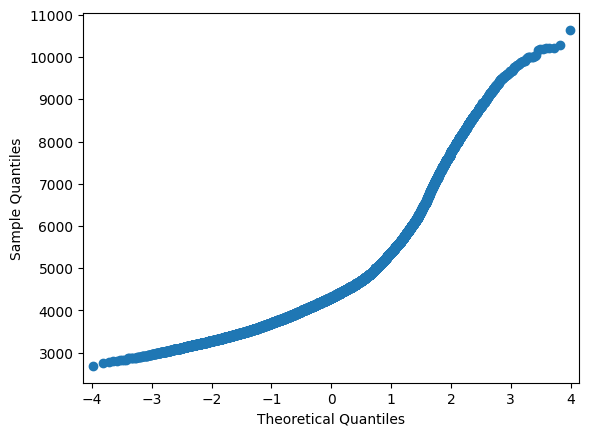

In [245]:
print(skew(train_df.resale_price_per_sqm))
print(skew(np.log(train_df.resale_price_per_sqm)))
fig = sm.qqplot(train_df.resale_price_per_sqm)
plt.show()

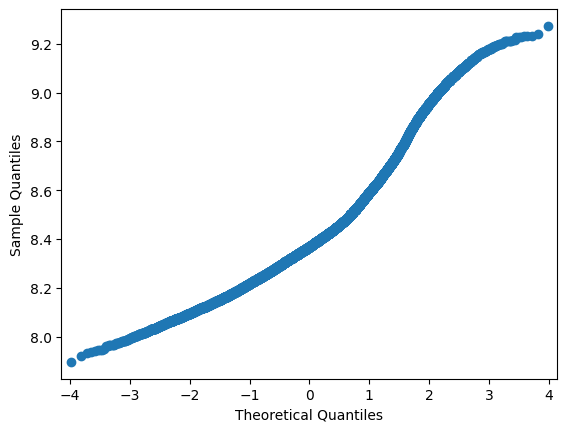

In [246]:
fig = sm.qqplot(np.log(train_df.resale_price_per_sqm))
plt.show()

In [247]:
X_train = train_df.drop(columns=["block", "street_name", "lease_commence_date", "resale_price_per_sqm"])
Y_train = train_df.resale_price_per_sqm

In [248]:
from sklearn.linear_model import Lasso

lasso_model = Lasso().fit(X_train, Y_train)
coefficients = lasso_model.coef_
features = np.array(X_train.columns)
importance = np.abs(coefficients)
print(np.array(features)[importance > 0])
print(np.array(features)[importance == 0])

['floor_area_sqm' 'remaining_lease' 'distance_cbd' 'distance_top_primary'
 'distance_mrt' '2015-03' '2015-07' '2015-10' 'ANG MO KIO' 'BEDOK'
 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG' 'BUKIT TIMAH'
 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG' 'HOUGANG'
 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE' 'PASIR RIS'
 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'TAMPINES' 'TOA PAYOH'
 'YISHUN' '3 ROOM' '4 ROOM' 'EXECUTIVE' '01 TO 03' '04 TO 06' '07 TO 09'
 '10 TO 12' '13 TO 15' '16 TO 18' '22 TO 24' 'DBSS' 'Improved'
 'Maisonette' 'Model A' 'Model A-Maisonette' 'Model A2' 'New Generation'
 'Premium Apartment' 'Simplified' 'Terrace' 'Type S1' 'Type S2']
['house_lat' 'house_long' '2015-01' '2015-02' '2015-04' '2015-05'
 '2015-06' '2015-08' '2015-09' '2015-11' '2015-12' '2016-01' '2016-02'
 '2016-03' '2016-04' '2016-05' '2016-06' '2016-07' '2016-08' '2016-09'
 '2016-10' '2016-11' '2016-12' 'SERANGOON' 'WOODLANDS' '1 ROOM' '2 ROOM'
 '5 ROOM' 'MULTI-GENERATION'

In [249]:
X_train = train_df.drop(columns=["block", "street_name", "lease_commence_date", "resale_price_per_sqm", "house_lat", "house_long", 
                                '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-11', '2015-12',
                                '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
Y_train = train_df.resale_price_per_sqm
X_test = test_df.drop(columns=["block", "street_name", "lease_commence_date", "resale_price_per_sqm", "house_lat", "house_long", 
                                '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-11', '2015-12',
                                '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12'])
Y_test = test_df.resale_price_per_sqm

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

elasticnet_model = Pipeline([
        ('scale', StandardScaler()),
        ('model', Lasso())])

elasticnet_model.fit(X_train, Y_train)
pred_train_y = elasticnet_model.predict(X_train)
pred_test_y = elasticnet_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train_y))
print(f"RMSE train: {rmse_train}")
rmse_test = np.sqrt(mean_squared_error(Y_test, pred_test_y))
print(f"RMSE test: {rmse_test}")
r2_test = r2_score(Y_test, pred_test_y)
print(f"r2 score: {r2_test}")

RMSE train: 445.2739296889196
RMSE test: 465.8043583105681
r2 score: 0.8168254048400676


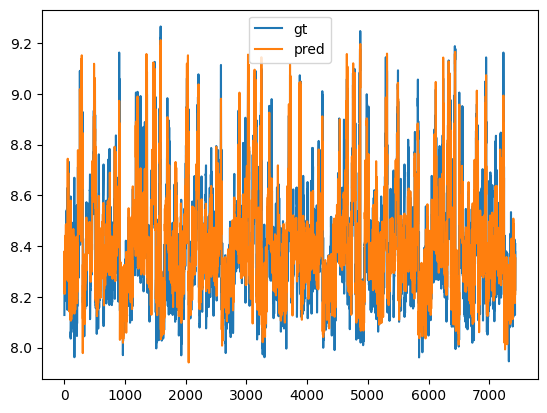

In [238]:
plt.plot(list(range(len(df) - int(0.8*len(df)))), Y_test, label="gt")
plt.plot(pred_test_y, label="pred")
plt.legend()

## Catboost

In [240]:
train_df = df[:int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]
X_train = train_df.drop(columns=["block", "street_name", "lease_commence_date", "resale_price_per_sqm", "house_lat", "house_long", "month"])
Y_train = train_df.resale_price_per_sqm
X_test = test_df.drop(columns=["block", "street_name", "lease_commence_date", "resale_price_per_sqm", "house_lat", "house_long", "month"])
Y_test = test_df.resale_price_per_sqm

In [241]:
# initialize Pool
train_pool = Pool(X_train, Y_train,
                  cat_features=["town", "flat_type", "storey_range", "flat_model"])
test_pool = Pool(X_test, Y_test,
                 cat_features=["town", "flat_type", "storey_range", "flat_model"])

# specify the training parameters 
model = CatBoostRegressor(iterations=500, 
                          loss_function='RMSE')

#train the model
model.fit(train_pool, eval_set=test_pool)
print(model.get_best_score())

# make the prediction using the resulting model
preds = model.predict(test_pool)
r2_test = r2_score(Y_test, preds)
print(f"r2 score: {r2_test}")

Learning rate set to 0.132372
0:	learn: 962.3868582	test: 998.6900310	best: 998.6900310 (0)	total: 51.3ms	remaining: 25.6s
1:	learn: 882.4898749	test: 920.5103076	best: 920.5103076 (1)	total: 63.4ms	remaining: 15.8s
2:	learn: 813.6180425	test: 851.8103940	best: 851.8103940 (2)	total: 76.5ms	remaining: 12.7s
3:	learn: 757.6684733	test: 796.9182803	best: 796.9182803 (3)	total: 87.1ms	remaining: 10.8s
4:	learn: 709.0686881	test: 749.3363376	best: 749.3363376 (4)	total: 98.5ms	remaining: 9.75s
5:	learn: 669.5154017	test: 709.5772359	best: 709.5772359 (5)	total: 108ms	remaining: 8.86s
6:	learn: 635.6928585	test: 677.0262751	best: 677.0262751 (6)	total: 116ms	remaining: 8.15s
7:	learn: 608.6139693	test: 650.5412548	best: 650.5412548 (7)	total: 126ms	remaining: 7.74s
8:	learn: 579.4173242	test: 622.1092527	best: 622.1092527 (8)	total: 146ms	remaining: 7.96s
9:	learn: 554.4460549	test: 595.7885792	best: 595.7885792 (9)	total: 154ms	remaining: 7.54s
10:	learn: 532.4174829	test: 573.4898368	best

15:	learn: 468.7294305	test: 504.1708967	best: 504.1708967 (15)	total: 192ms	remaining: 5.8s
16:	learn: 460.6845462	test: 494.2155178	best: 494.2155178 (16)	total: 197ms	remaining: 5.6s
17:	learn: 452.7322116	test: 486.2246928	best: 486.2246928 (17)	total: 203ms	remaining: 5.45s
18:	learn: 443.7749761	test: 476.6858168	best: 476.6858168 (18)	total: 215ms	remaining: 5.44s
19:	learn: 436.1969852	test: 468.8369022	best: 468.8369022 (19)	total: 222ms	remaining: 5.34s
20:	learn: 431.2789711	test: 463.1002126	best: 463.1002126 (20)	total: 228ms	remaining: 5.2s
21:	learn: 424.3595772	test: 455.0197851	best: 455.0197851 (21)	total: 241ms	remaining: 5.24s
22:	learn: 417.9512856	test: 447.9275763	best: 447.9275763 (22)	total: 250ms	remaining: 5.18s
23:	learn: 413.7524814	test: 443.1289675	best: 443.1289675 (23)	total: 255ms	remaining: 5.07s
24:	learn: 409.7358161	test: 439.2208120	best: 439.2208120 (24)	total: 263ms	remaining: 4.99s
25:	learn: 406.7836739	test: 436.1231598	best: 436.1231598 (25)

Text(0.5, 1.0, 'Feature Importance (Top 5)')

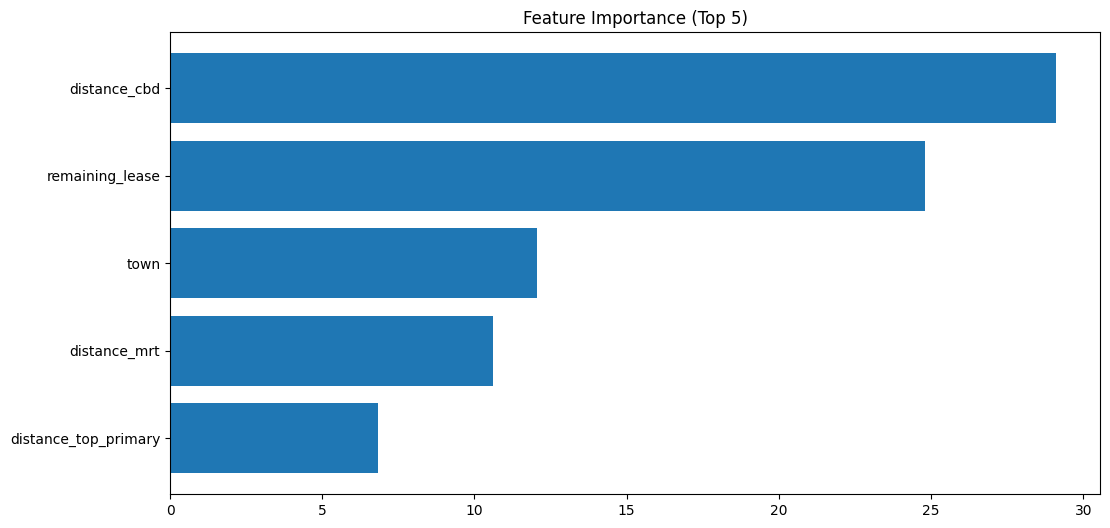

In [242]:
feature_importance = model.get_feature_importance(train_pool)
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(5), feature_importance[sorted_idx][-5:], align='center')
plt.yticks(range(5), np.array(X_train.columns)[sorted_idx][-5:])
plt.title('Feature Importance (Top 5)')


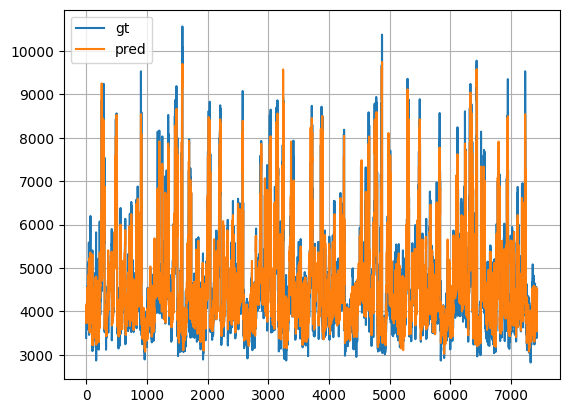

In [177]:
plt.plot(list(range(len(df) - int(0.8*len(df)))), Y_test, label="gt")
plt.plot(preds, label="pred")
plt.grid()
plt.legend()

# Conclusion

- Using additional features such as distance to cbd and distance to nearest mrt helps. 
- Catboost performed better than linear regression based methods
- Even though log transformation could help to correct the skew of the target variable, it seemed to decrease performance. An unusual behavior was also observed with Lasso regression where all coefficients became 0 when log transformation was performed on target variable.

Potential ways to improve
- Use routing distance from OneMapApi
- Explore using past time series data (e.g. past year average prices from the same town of the same flat type), similar to an ARIMAX model (ARIMA + exogeneous variables)